In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from keras import backend
%config Completer.use_jedi = False

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import SGD
from matplotlib import pyplot as plt
import sys

Using TensorFlow backend.
/home/aman/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/aman/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/aman/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/aman/anaconda3/envs/ml/lib/pytho

In [2]:
def load_dataset():
    data = np.load('./planet_data.npz')
    X, y = data['arr_0'], data['arr_1']
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=1)
    print(trainX.shape, testX.shape, trainY.shape, testY.shape)
    return trainX, testX, trainY, testY

In [3]:
def fbeta(y_true, y_pred, beta=2):
    y_pred = backend.clip(y_pred, 0, 1)
    
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    
    p = tp/(tp + fp + backend.epsilon())
    r = tp/(tp + fn + backend.epsilon())
    bb = beta ** 2
    fbeta_score = backend.mean((1+bb) * (p*r) / (bb*p + r + backend.epsilon()))
    return fbeta_score

In [4]:
'''
trainX, testX, trainY, testY = load_dataset()

# make all one predictions
train_yhat = np.asarray([np.ones(trainY.shape[1]) for _ in range(trainY.shape[0])])
test_yhat = np.asarray([np.ones(testY.shape[1]) for _ in range(testY.shape[0])])

# evaluate predictions with sklearn
train_score = fbeta_score(trainY, train_yhat, 2, average='samples')
test_score = fbeta_score(testY, test_yhat, 2, average='samples')
print('All Ones (sklearn): train=%.3f, test=%.3f' % (train_score, test_score))

# evaluate predictions with keras
train_score = fbeta(backend.variable(trainY), backend.variable(train_yhat))
test_score = fbeta(backend.variable(testY), backend.variable(test_yhat))
print('All Ones (keras): train=%.3f, test=%.3f' % (train_score, test_score))
'''

"\ntrainX, testX, trainY, testY = load_dataset()\n\n# make all one predictions\ntrain_yhat = np.asarray([np.ones(trainY.shape[1]) for _ in range(trainY.shape[0])])\ntest_yhat = np.asarray([np.ones(testY.shape[1]) for _ in range(testY.shape[0])])\n\n# evaluate predictions with sklearn\ntrain_score = fbeta_score(trainY, train_yhat, 2, average='samples')\ntest_score = fbeta_score(testY, test_yhat, 2, average='samples')\nprint('All Ones (sklearn): train=%.3f, test=%.3f' % (train_score, test_score))\n\n# evaluate predictions with keras\ntrain_score = fbeta(backend.variable(trainY), backend.variable(train_yhat))\ntest_score = fbeta(backend.variable(testY), backend.variable(test_yhat))\nprint('All Ones (keras): train=%.3f, test=%.3f' % (train_score, test_score))\n"

In [5]:
def define_model(in_shape=(128, 128, 3), out_shape=17):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(out_shape, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model

In [6]:
def summarize_diagnostics(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Fbeta')
    plt.plot(history.history['fbeta'], color='blue', label='train')
    plt.plot(history.history['val_fbeta'], color='orange', label='test')
    plt.show()

In [7]:
def run_test_harness():
    # load dataset
    print("Loading dataset...")
    trainX, testX, trainY, testY = load_dataset()
    # create data generator
    print("Creating data generator...")
    train_datagen = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, vertical_flip=True, rotation_range=90)
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterators
    print("Preparing iterators... ")
    train_it = train_datagen.flow(trainX, trainY, batch_size=128)
    test_it = test_datagen.flow(testX, testY, batch_size=128)
    # define model
    print("Building model... ")
    model = define_model()
    # fit model
    print("Training...")
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=30, verbose=1)
    # evaluate model
    print("Evaluating...")
    loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
    # learning curves
    summarize_diagnostics(history)

Loading dataset...
(28335, 128, 128, 3) (12144, 128, 128, 3) (28335, 17) (12144, 17)
Creating data generator...
Preparing iterators... 
Building model... 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Training...

Epoch 1/30
222/222 [==============================] - 110s 496ms/step - loss: 0.2816 - fbeta: 0.6218 - val_loss: 0.2605 - val_fbeta: 0.6958
Epoch 2/30
222/222 [==============================] - 99s 446ms/step - loss: 0.2315 - fbeta: 0.6730 - val_loss: 0.2541 - val_fbeta: 0.7148
Epoch 3/30
222/222 [==============================] - 101s 455ms/step - loss: 0.2219 - fbeta: 0.6851 - val_loss: 0.2225 - val_fbeta: 0.7029
Epoch 4/30
222/222 [==============================] - 97s 437ms/step - loss: 0.2151 - fbeta: 0.6949 - val_loss: 0.1969 - val_fbeta: 0.6982
Epoch 5/30
222/222 [==============================] - 99s 447ms/step - loss: 0.2110 - fbeta: 0.6986 - val_loss: 0.2147 - val_fbeta: 0.7245
Epoch 6/30
222/222 [====================

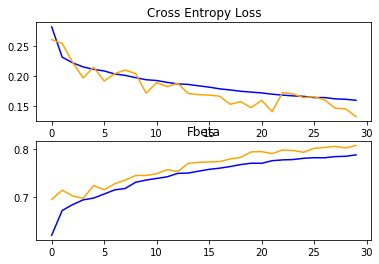

In [8]:
run_test_harness()